In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from IPython.display import clear_output
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate
from keras.preprocessing import image
from keras.callbacks import Callback
from keras.applications.vgg16 import VGG16, preprocess_input
import pandas as pd
from keras import backend as K

In [2]:
from google.colab import files
src = list(files.upload().values())[0]
open('UNet_impl1.py','wb').write(src)

Saving UNet_impl1.py to UNet_impl1 (16).py


1485

In [3]:
src = list(files.upload().values())[0]
open('UNet_impl2.py','wb').write(src)

Saving UNet_impl2.py to UNet_impl2 (13).py


1554

In [4]:
import UNet_impl1 as unet1
import UNet_impl2 as unet2

In [5]:
# TODO: Add import file and dataset from git

In [6]:
from google.colab import drive
drive.mount('myDrive')

Drive already mounted at myDrive; to attempt to forcibly remount, call drive.mount("myDrive", force_remount=True).


In [7]:
DIR_PATH = '/content/myDrive/MyDrive/camVid/CamVid/'

In [8]:
class_dict = pd.read_csv(os.path.join(DIR_PATH + 'class_dict.csv'), index_col=0)
class_dict.head()

,r,g,b
name,,,
Animal,64,128,64
Archway,192,0,128
Bicyclist,0,128,192
Bridge,0,128,64
Building,128,0,0


In [9]:
cls2rgb = {cl:list(class_dict.loc[cl, :]) for cl in class_dict.index}
idx2rgb={idx:np.array(rgb) for idx, (cl, rgb) in enumerate(cls2rgb.items())}
idx2rgb

{0: array([ 64, 128,  64]),
 1: array([192,   0, 128]),
 2: array([  0, 128, 192]),
 3: array([  0, 128,  64]),
 4: array([128,   0,   0]),
 5: array([ 64,   0, 128]),
 6: array([ 64,   0, 192]),
 7: array([192, 128,  64]),
 8: array([192, 192, 128]),
 9: array([ 64,  64, 128]),
 10: array([128,   0, 192]),
 11: array([192,   0,  64]),
 12: array([128, 128,  64]),
 13: array([192,   0, 192]),
 14: array([128,  64,  64]),
 15: array([ 64, 192, 128]),
 16: array([64, 64,  0]),
 17: array([128,  64, 128]),
 18: array([128, 128, 192]),
 19: array([  0,   0, 192]),
 20: array([192, 128, 128]),
 21: array([128, 128, 128]),
 22: array([ 64, 128, 192]),
 23: array([ 0,  0, 64]),
 24: array([ 0, 64, 64]),
 25: array([192,  64, 128]),
 26: array([128, 128,   0]),
 27: array([192, 128, 192]),
 28: array([64,  0, 64]),
 29: array([192, 192,   0]),
 30: array([0, 0, 0]),
 31: array([ 64, 192,   0])}

In [37]:
class CamVidDataset():
    
    def __init__(self, DIR_PATH):
        self.train_images = self.readData(os.path.join(DIR_PATH + 'train'))
        self.train_masks = self.readData(os.path.join(DIR_PATH + 'train_labels'))
        self.test_images = self.readData(os.path.join(DIR_PATH + 'test'))
        self.test_masks = self.readData(os.path.join(DIR_PATH + 'test_labels'))
        self.val_images = self.readData(os.path.join(DIR_PATH + 'val'))
        self.val_masks = self.readData(os.path.join(DIR_PATH + 'val_labels'))
        
                                          
    def readData(self, DirPath):
        img_names = []
        for f in os.listdir(DirPath):
            img_names.append(os.path.join(DirPath,f))
        img_names.sort()
        
        res = []
        for i in img_names:
            res.append(image.load_img(i, target_size=(128, 128)))
        return np.array(res)


In [38]:
dataset = CamVidDataset(DIR_PATH)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [39]:
dataset.train_images.shape

(369,)

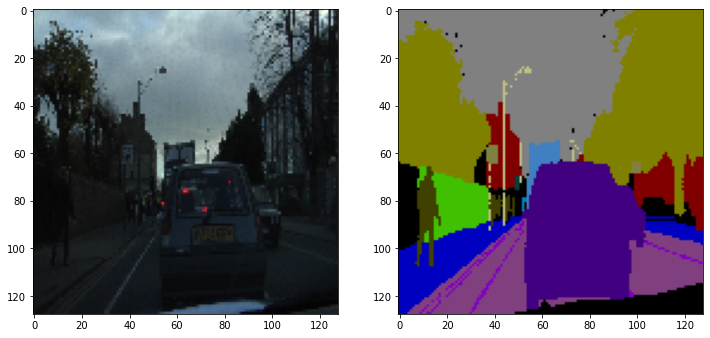

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(dataset.train_images[0].convert('RGBA'))
ax[1].imshow(dataset.train_masks[0].convert('RGBA'))

In [41]:
X_train = []

for img in dataset.train_images:
  x = image.img_to_array(img)
  X_train.append(x)

X_train = np.array(X_train)
print(X_train.shape)

X_test = []

for img in dataset.test_images:
  x = image.img_to_array(img)
  X_test.append(x)

X_test = np.array(X_test)
print(X_test.shape)

X_val = []

for img in dataset.val_images:
  x = image.img_to_array(img)
  X_val.append(x)

X_val = np.array(X_val)
print(X_val.shape)

(369, 128, 128, 3)
(232, 128, 128, 3)
(100, 128, 128, 3)


In [42]:
arr_col = []

for r, g, b in zip(class_dict['r'], class_dict['g'], class_dict['b']):
  arr_col.append([r, g, b]) 

def Color2index(y, arr_col=arr_col):
    y_ind = np.zeros((y.shape[0], y.shape[1]))
    y_cat = np.zeros((y.shape[0], y.shape[1], len(arr_col)))
    i = 1
    for i_color in arr_col:
        ind_i = np.where(
            (y[..., 0] == i_color[0]) 
            & (y[..., 1] == i_color[1])
            & (y[..., 2] == i_color[2])
        )
        y_ind[ind_i[0], ind_i[1]] = i
        y_cat[ind_i[0], ind_i[1], i-1] = 1 
        i += 1
    
    return y_cat, y_ind#, i-1

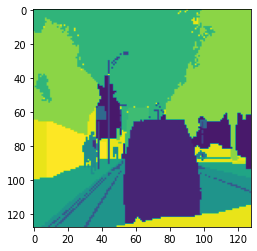

In [43]:
cat_yi, ind_yi = Color2index(image.img_to_array(dataset.train_masks[3]))
plt.imshow(ind_yi)
plt.show()  

In [44]:
ind_yi

array([[22., 22., 22., ..., 27., 27., 27.],
       [22., 22., 22., ..., 27., 27., 27.],
       [22., 22., 22., ..., 27., 27., 27.],
       ...,
       [20., 20., 20., ..., 31., 31., 31.],
       [20., 20., 20., ..., 31., 31., 31.],
       [20., 20., 20., ..., 31., 31., 31.]])

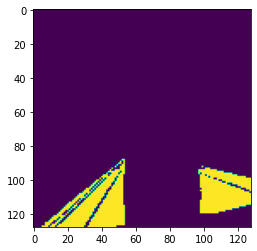

In [45]:
plt.imshow(cat_yi[..., 17])
plt.show()

In [46]:
cat_yi.shape

(128, 128, 32)

In [47]:
y_train = []

for mask in dataset.train_masks:
  y_cat, _ = Color2index(image.img_to_array(mask))
  y_train.append(y_cat)

y_train = np.array(y_train)

y_test = []

for mask in dataset.test_masks:
  y_cat, _ = Color2index(image.img_to_array(mask))
  y_test.append(y_cat)

y_test = np.array(y_test)

y_val = []

for mask in dataset.val_masks:
  y_cat, _ = Color2index(image.img_to_array(mask))
  y_val.append(y_cat)

y_val = np.array(y_val)

print(X_train.shape)
print(y_train.shape)

(369, 128, 128, 3)
(369, 128, 128, 32)


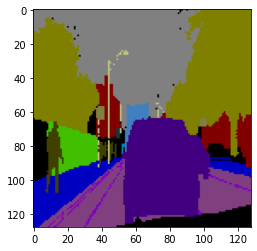

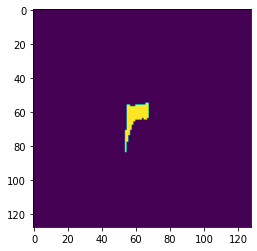

In [48]:
n = 0
plt.imshow(dataset.train_masks[n].convert('RGBA'))
plt.show()
img = y_train[n][..., 22]

plt.imshow(img)
plt.show()

In [49]:
smooth=1.

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [50]:
model1 = unet1.build_unet(32, (128, 128, 3))
model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[iou, dice_coef])

In [51]:
model2 = unet2.build_unet(32, (128, 128, 3))
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[iou, dice_coef])

In [52]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [53]:
TRAIN_LENGTH = len(dataset.train_images)
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(dataset.test_images)//BATCH_SIZE//VAL_SUBSPLITS

In [54]:
sample_image = X_test[1]
sample_mask = y_test[1]

In [55]:
def map_class_to_rgb(p):
    return idx2rgb[p[0]]

def show_prediction(model, ind, dataset_images, dataset_masks, images):
    img = images[ind]
    img = np.expand_dims(img,axis=0) # (128, 128, 3)
    pred_mask = model.predict(img) # (1, 128, 128, 3)
    pred_mask = np.argmax(pred_mask, axis=-1) # (1, 128, 128)
    rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(pred_mask, -1))
    rgb_mask = rgb_mask.reshape((128, 128, 3))
    fig, ax = plt.subplots(1, 3, figsize=(12, 12))
    ax[0].imshow(dataset_images[ind].convert('RGBA'))
    ax[1].imshow(dataset_masks[ind])
    ax[2].imshow(rgb_mask)
    plt.show()
    

In [56]:
def show_predictions(model):
    pred_mask = model.predict(sample_image[None])[..., 16]
    print(pred_mask.shape)

    fig, ax = plt.subplots(1, 3, figsize=(15, 8))

    ax[0].imshow(sample_image / 255.0)
    ax[1].imshow(sample_mask[..., 16])
    ax[2].imshow(np.squeeze(pred_mask, axis=0))
    plt.show()


class DisplayCallback(Callback):
    def __init__(self, patience=1):
        super().__init__()
        self.patience = patience
    
    def on_train_begin(self, logs=None):
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        self.wait += 1
        if self.wait >= self.patience:
            clear_output(wait=True)
            show_prediction(self.model, 0, dataset.train_images, dataset.train_masks, X_train)
            print(f'\nSample Prediction after epoch {epoch+1}')
            self.wait = 0

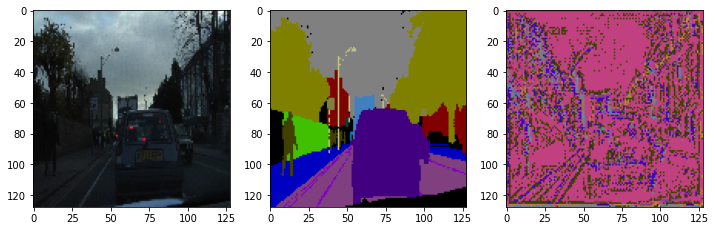

In [57]:
show_prediction(model1, 0, dataset.train_images, dataset.train_masks, X_train)

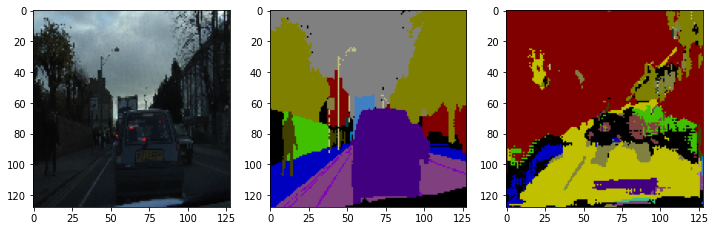


Sample Prediction after epoch 100
37/37 [==============================] - 8s 217ms/step - loss: 0.5182 - iou: 0.6460 - dice_coef: 0.7843 - val_loss: 0.8155 - val_iou: 0.5764 - val_dice_coef: 0.7249


In [31]:
history = model1.fit(preprocess_input(X_train), y_train,
                      epochs=100,
                      batch_size=10,
                      validation_data=(preprocess_input(X_test), y_test),
                      callbacks=[DisplayCallback(patience=5)])

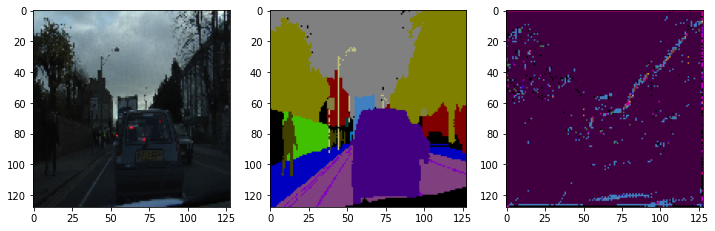

In [58]:
show_prediction(model2, 0, dataset.train_images, dataset.train_masks, X_train)

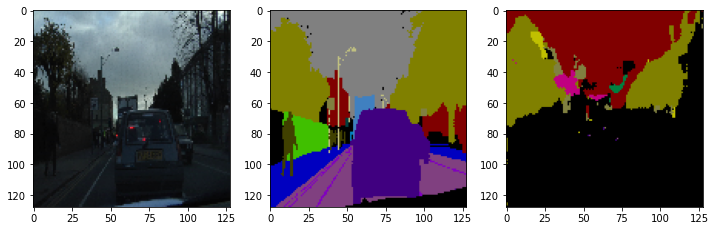


Sample Prediction after epoch 100
37/37 [==============================] - 9s 236ms/step - loss: 0.1271 - iou: 0.8758 - dice_coef: 0.9337 - val_loss: 0.6198 - val_iou: 0.7150 - val_dice_coef: 0.8299


In [59]:
 history = model2.fit(preprocess_input(X_train), y_train,
                      epochs=100,
                      batch_size=10,
                      validation_data=(preprocess_input(X_test), y_test),
                      callbacks=[DisplayCallback(patience=5)])

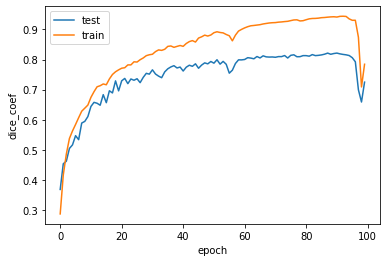

In [32]:
 plt.plot(model1.history.history['val_dice_coef'], label='test')
plt.plot(model1.history.history['dice_coef'], label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

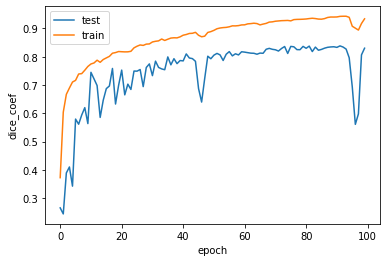

In [60]:
plt.plot(model2.history.history['val_dice_coef'], label='test')
plt.plot(model2.history.history['dice_coef'], label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

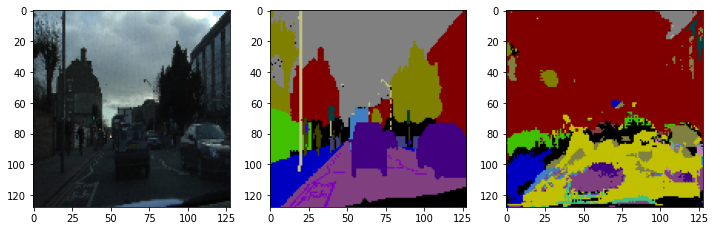

In [33]:
show_prediction(model1, 10, dataset.train_images, dataset.train_masks, X_train)

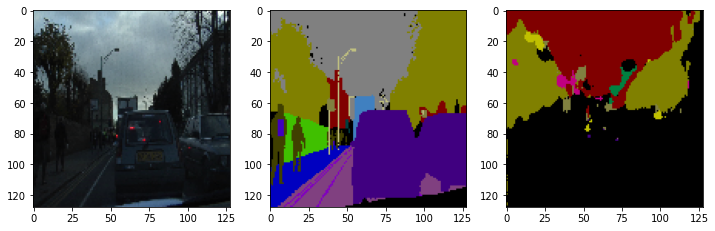

In [61]:
show_prediction(model2, 1, dataset.train_images, dataset.train_masks, X_train)

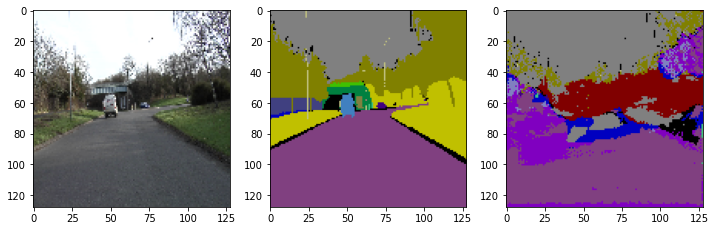

In [34]:
show_prediction(model1, 10, dataset.val_images, dataset.val_masks, X_val)

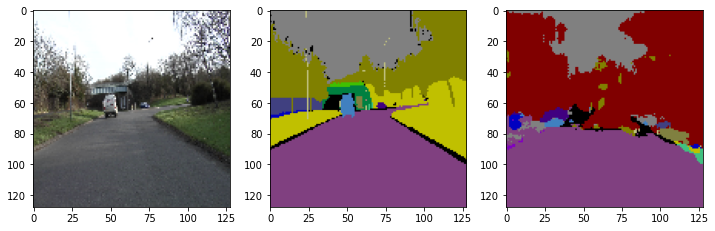

In [62]:
show_prediction(model2, 10, dataset.val_images, dataset.val_masks, X_val)